# Sheet 3: Solution

In [0]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

## Exercise 1: Variance of beta

To compute the covariance of the components of 
the vector $\hat\beta = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T Y$
we assume $Y = X^T \beta + \epsilon$ with $\epsilon \sim \mathcal{N}(0,\sigma^2)$, as 
specified on the sheet. This assumes that the whole randomness of $Y$
comes from $\epsilon$, given knowledge of $X$. Therefore

\begin{align}
\text{Var}_{Y|X}(\hat\beta) 
& = E_{Y|X} \left[(\hat\beta - E_{Y|X}(\hat\beta)) (\hat\beta - E_{Y|X}(\hat\beta))^T\right] \\
& = E_{Y|X} \left[ \big((\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T (X^T\beta + \epsilon) - (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T X^T\beta )\big) \big(...\big)^T \right] \\
& = E_{Y|X} \left[ (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \epsilon  \epsilon \mathbf{X} (\mathbf{X}^T \mathbf{X})^{-1}  \right] \\
& = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T E_{Y|X} \left[ \epsilon  \epsilon \right] \mathbf{X} (\mathbf{X}^T \mathbf{X})^{-1} \\
& = (\mathbf{X}^T \mathbf{X})^{-1} \sigma^2.
\end{align}

## Exercise 2: Ridge regression

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd '/content/drive/My Drive/Colab Notebooks/statisticallearning-2020/Sheet03/solution'

pcancer = pd.read_csv("prostate.csv",delimiter=',')

pcancer.head(8)

/content/drive/My Drive/Colab Notebooks/statisticallearning-2020/Sheet03/solution


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,True
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,True
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,True
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,True
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,True
5,-1.049822,3.228826,50,-1.386294,0,-1.386294,6,0,0.765468,True
6,0.737164,3.473518,64,0.615186,0,-1.386294,6,0,0.765468,False
7,0.693147,3.539509,58,1.536867,0,-1.386294,6,0,0.854415,True


Split training and testing data

In [0]:
# There's a training sub-dataset that we will focus on. Later, we will try to predict
# the values of the remaining observations.
col_num = 8
Xtrain = pcancer.loc[pcancer['train'] == True,pcancer.columns[0:col_num]]
ytrain = pcancer.loc[pcancer['train'] == True,pcancer.columns[col_num]]
Xtrain.head(8)


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0
5,-1.049822,3.228826,50,-1.386294,0,-1.386294,6,0
7,0.693147,3.539509,58,1.536867,0,-1.386294,6,0
10,0.254642,3.604138,65,-1.386294,0,-1.386294,6,0


In [0]:
Xtest = pcancer.loc[pcancer['train'] == False,pcancer.columns[0:col_num]]
ytest = pcancer.loc[pcancer['train'] == False,pcancer.columns[col_num]]
Xtest.head(8)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
6,0.737164,3.473518,64,0.615186,0,-1.386294,6,0
8,-0.776529,3.539509,47,-1.386294,0,-1.386294,6,0
9,0.223144,3.244544,63,-1.386294,0,-1.386294,6,0
14,1.205971,3.442019,57,-1.386294,0,-0.430783,7,5
21,2.059239,3.501043,60,1.474763,0,1.348073,7,20
24,0.385262,3.667400,69,1.599388,0,-1.386294,6,0
25,1.446919,3.124565,68,0.300105,0,-1.386294,6,0
27,-0.400478,3.865979,67,1.816452,0,-1.386294,7,20


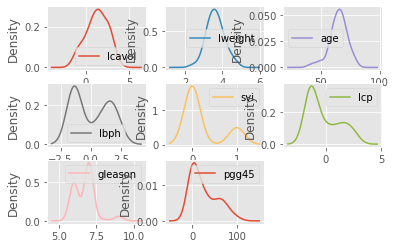

In [0]:
# Analysis of prostate-specific antigen and clinical measures
# among men who were about to have their prostates removed
# - lcavol : log(cancer volume)
# - lweight : log(prostate weight)
# - age : age
# - lbph : log(benign prostatic hyperplasia)
# - svi : seminal vesicle invasion
# - lcp : log(capsular penetration)
# - gleason : Gleason score
# - pgg45 : percent of Gleason scores 4 or 5

# - lpsa : log(prostate-specific antigen)

Xtrain.plot(kind = 'density', subplots = True, layout = (3,3),sharex=False)
plt.show()

[Text(0, 0, 'lcavol'),
 Text(0, 0, 'lweight'),
 Text(0, 0, 'age'),
 Text(0, 0, 'lbph'),
 Text(0, 0, 'svi'),
 Text(0, 0, 'lcp'),
 Text(0, 0, 'gleason'),
 Text(0, 0, 'pgg45')]

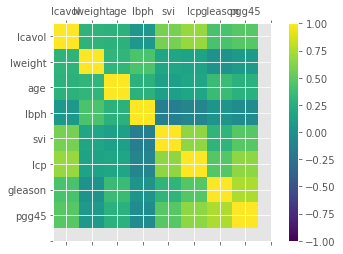

In [0]:
# We see that there are many strong correlations between features
# and lpsa. Therefore we need to fit the effects jointly to
# disentangle the relationships between the features and lpsa.

names = list(Xtrain)
correlations = Xtrain.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)

In [0]:
# scale data sets to have zero mean and unit variance, but do not adjust lpsa
from sklearn import linear_model,preprocessing


# Xtrain = preprocessing.scale(Xtrain)
Xtrain_mean = np.mean(Xtrain)
Xtrain_std = np.std(Xtrain)
print(Xtrain_mean)
print(Xtrain_std)
# Scale training data to have zero mean and unit variance (standard derivation)
Xtrain = (Xtrain-Xtrain_mean)/Xtrain_std

Xtest.head(8)
# Scale testing data using training mean and trainig standard derivation
Xtest = (Xtest-Xtrain_mean)/Xtrain_std

lcavol      1.313492
lweight     3.626108
age        64.746269
lbph        0.071440
svi         0.223881
lcp        -0.214203
gleason     6.731343
pgg45      26.268657
dtype: float64
lcavol      1.233282
lweight     0.473031
age         7.446011
lbph        1.452691
svi         0.416843
lcp         1.390243
gleason     0.703554
pgg45      29.082272
dtype: float64


In [0]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression(fit_intercept=True).fit(Xtrain, ytrain)
print(linear_reg.predict(Xtest))
print(ytest)

[1.96903844 1.16995577 1.26117929 1.88375914 2.54431886 1.93275402
 2.04233571 1.83091625 1.99115929 1.32347076 2.93843111 2.20314404
 2.166421   2.79456237 2.67466879 2.18057291 2.40211068 3.02351576
 3.21122283 1.38441459 3.41751878 3.70741749 2.54118337 2.72969658
 2.64055575 3.48060024 3.17136269 3.2923494  3.11889686 3.76383999]
6     0.765468
8     1.047319
9     1.047319
14    1.398717
21    1.658228
24    1.731656
25    1.766442
27    1.816452
31    2.008214
33    2.021548
35    2.085672
41    2.307573
43    2.374906
47    2.568788
48    2.591516
49    2.591516
52    2.684440
53    2.691243
54    2.704711
56    2.788093
61    2.853592
63    2.882004
64    2.882004
65    2.887590
72    3.056357
73    3.075006
79    3.513037
83    3.570940
94    5.143124
96    5.582932
Name: lpsa, dtype: float64


In [0]:
from sklearn.linear_model import Ridge
n_alphas = 5000
lam= np.logspace(-10, 3, n_alphas)
model_ridge_coef = np.zeros((lam.shape[0],9))
sample_num = Xtrain.shape[0]
for i in range(lam.shape[0]):
    model_ridge = Ridge(alpha=lam[i], fit_intercept=True)
    model_ridge.fit(Xtrain, ytrain)
    model_ridge_coef[i,:]=np.concatenate((model_ridge.intercept_.reshape(-1),model_ridge.coef_),axis=0)
    

Text(0.5, 0, 'Regularisation parameter $\\lambda$')

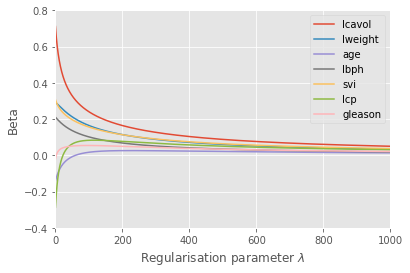

In [0]:
plt.figure()
plt.plot(lam,model_ridge_coef[:,1:-1])
plt.ylim(-0.4,0.8)
plt.xlim(min(lam),max(lam))
plt.legend(names[0:8])
plt.ylabel('Beta')
plt.xlabel('Regularisation parameter $\lambda$')

The number of degrees of freedom is given as: 
    $df(\lambda)=\text{tr}[\mathbf{X}(\mathbf{X}^T \mathbf{X}+\lambda\mathbf{I})^{-1}\mathbf{X}^T]$
    

In [0]:
# compute the degrees of freedom for each value of lambda
D = np.concatenate((np.ones(Xtrain.shape[0]).reshape(-1,1),Xtrain),axis=1)
# print(np.concatenate((np.ones(Xtrain.shape[0]).reshape(-1,1),Xtrain),axis=1))
for i in range(lam.shape[0]):
    lam_i = lam[i]
    # compute the ridge-regression beta hat estimates:
    iden_mat = np.zeros((col_num+1,col_num+1))
    np.fill_diagonal(iden_mat,1)
    M = np.linalg.pinv(np.transpose(D).dot(D)+lam[i]*iden_mat).dot(np.transpose(D))
    # this is just an alternative way of estimating the coefficients of the Ridge regression  
    betaHat = M.dot(ytrain)
    # compute the degrees of freedom for this values of lambda:
    dof = np.sum( np.diag(D.dot(M)) ) 
    # each column is a different value of the complexity parameter ...
    if i == 0:
        betaRes = betaHat.reshape(-1,1)
        dofRes = dof
    else:
        betaRes = np.concatenate((betaRes,betaHat.reshape(-1,1)),axis=1)
        dofRes = np.append(dofRes,dof)

Plot the calcuated betaRes as a function of dofRes (degree of freedom)

(5000, 9)


Text(0, 0.5, 'Beta')

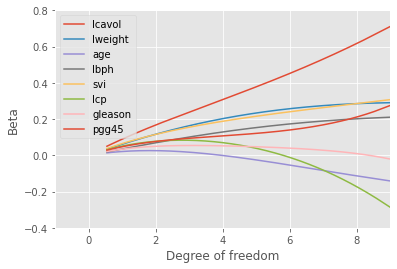

In [0]:
print(np.transpose(betaRes).shape)
plt.figure()
plt.plot(dofRes,np.transpose(betaRes[1:,:]))
plt.ylim(-0.4,0.8)
plt.xlim(-1,9)
plt.legend(names[0:8])
plt.xlabel('Degree of freedom')
plt.ylabel('Beta')

Make a comparison with the ridge coefficients outputed by Sklearn build-in functions

(9, 5000)


Text(0, 0.5, 'Beta')

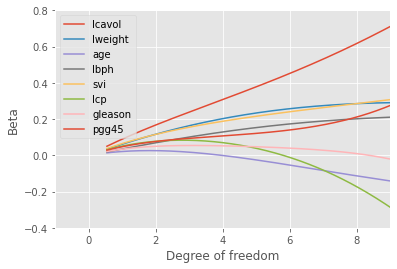

In [0]:
print(np.transpose(model_ridge_coef).shape)
plt.figure()
plt.plot(dofRes,model_ridge_coef[:,1:])
plt.ylim(-0.4,0.8)
plt.xlim(-1,9)
plt.legend(names[0:8])
plt.xlabel('Degree of freedom')
plt.ylabel('Beta')

In [0]:
from sklearn.linear_model import RidgeCV
optim_ridge = RidgeCV(alphas=lam,fit_intercept=True).fit(Xtrain, ytrain)
print('optimal regression strength lambda is:', optim_ridge.alpha_)

optimal regression strength lambda is: 3.6367390713831975


In [0]:
print('training error of ridge regression:',np.linalg.norm(np.array(ytrain) - optim_ridge.predict(Xtrain)))
print('training error of linear regression:',np.linalg.norm(np.array(ytrain)-linear_reg.predict(Xtrain)))
print('testing error of ridge regression:',np.linalg.norm(np.array(ytest) - optim_ridge.predict(Xtest)))
print('testing error of linear regression:',np.linalg.norm(np.array(ytest)-linear_reg.predict(Xtest)))

training error of ridge regression: 5.455644395678778
training error of linear regression: 5.424609152732425
testing error of ridge regression: 3.866536391680983
testing error of linear regression: 3.9545189549713884


## Exercise 3: knn and linear regression compared

For simplicity we assume that $y$ and $x$ are scalars, $X \subset \mathbb R, Y \subset \mathbb R, $. Then we can write $Y^T = (y_1,\ldots,y_n)$ and $X^T = \begin{pmatrix}
  1 & \ldots & 1 \\
  x_1 & \ldots & x_n 
 \end{pmatrix}$ 

<b>Part 1. 
+ Linear Regression.</b> From exercise 1, we have $\hat \beta = (X^T X)^{-1} X^T Y$ and then set

$$ f_S(x_0) = [x_0 1] \hat \beta = [x_0 1] (X^T X)^{-1} X^T Y.$$

Then, $\omega_i(x_0, X) = [x_0 1] (X^T X)^{-1} \begin{bmatrix} 1 \\ x_i \end{bmatrix},$ for each $i: 1\leq i \leq n.$

 We can also write more explicitly, 
    $X^T X = 
    \begin{pmatrix}
    n & \sum x_i \\
    \sum x_i & \sum x_i^2 
    \end{pmatrix},$
    
 which has determinant $(n-1) \sum_i x_i^2 - 2n \sum_{i<j} x_i x_j.$ This allows us to calculate $(X^T X)^{-1}$ and $\omega_i(x_0, X)$ even more explicitly. 
    
+ <b>k-NN.</b>  The weights are equal $\omega_i(x_0, X) = \frac 1k$ if $x_i$ is one of the nearest
$k$ points and 0 otherwise.

   

<b>Part 2. </b> By a standard decomposition,
$$
E_{Y|X} ( (f(x_0) - f_S(x_0))^2 )= f(x_0)^2 - 2 f(x_0) E_{Y|X} (f_S(x_0)) + E_{Y|X} ((f_S(x_0))^2) \\
= (f(x_0) - E_{Y|X} (f_S(x_0)))^2 + E_{Y|X} ((f_S(x_0))^2) - (E_{Y|X} (f_S(x_0)))^2 \\
= (f(x_0) - E_{Y|X} (f_S(x_0)))^2 + \mathtt{Var}_{Y|X} (f_S(x_0))
$$

The
first term on the right hand side is the squared conditional bias, whereas the second term is the conditional variance. Because of the conditioning,
we have, for linear estimators,
$$\mathtt{Var}_{Y|X} (f_S(x_0)) = \sigma^2 \sum_i \omega_i^2 (x_0, X)$$

and

$$ \mathtt{Bias}_{Y|X}^2 (f_S(x_0)) = \left(f(x_0)  - \sum_i \omega_i (x_0, X) f(x_i)  \right)^2$$ 

<b>Part 3. </b> The calculation goes into the same way as in Part 2, except that both $X$ and $Y$ vary.

$$
E_{X,Y} ( (f(x_0) - f_S(x_0))^2 )= f(x_0)^2 - 2 f(x_0) E_{X,Y} (f_S(x_0)) + E_{X,Y} (f_S(x_0))^2 \\
= (f(x_0) - E_{X,Y} (f_S(x_0)))^2 + E_{X,Y} (f_S(x_0))^2 - (E_{X,Y} (f_S(x_0)))^2 \\
= \mathtt{Bias}^2 (f_s(x_0)) + \mathtt{Var} (f_S(x_0)).
$$


